In [141]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError, Huber
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler

In [186]:
model_name = './standardized_cnn.keras'

In [202]:
foot_mat = loadmat('./JointLoad Data/foot_raw_clean.mat')
jointload_mat = loadmat('./JointLoad Data/jointload_raw_clean.mat')
angle_mat = loadmat('./JointLoad Data/angle_data.mat')

f1_foot_data = foot_mat['f1']
f2_foot_data = foot_mat['f2']
f3_foot_data = foot_mat['f3']

f1_jointload_data = jointload_mat['f1']
f2_jointload_data = jointload_mat['f2']
f3_jointload_data = jointload_mat['f3']

f1_angle_data = [np.interp(np.linspace(0, 1, 1000), np.linspace(0, 1, 30), i) for i in angle_mat['f1']]
f2_angle_data = [np.interp(np.linspace(0, 1, 1000), np.linspace(0, 1, 30), i) for i in angle_mat['f2']]
f3_angle_data = [np.interp(np.linspace(0, 1, 1000), np.linspace(0, 1, 30), i) for i in angle_mat['f3']]

foot_data = np.vstack((f1_foot_data, f2_foot_data, f3_foot_data))
angle_data = np.vstack((f1_angle_data, f2_angle_data, f3_angle_data))

scaler = StandardScaler()
standardized_foot_data = scaler.fit_transform(foot_data)
angle_scaler = StandardScaler()
standardized_angle_data = angle_scaler.fit_transform(angle_data)

f1_standardized_foot_data = standardized_foot_data[0:len(f1_foot_data)]
f2_standardized_foot_data = standardized_foot_data[len(f1_foot_data): len(f1_foot_data) + len(f2_foot_data)]
f3_standardized_foot_data = standardized_foot_data[len(f1_foot_data) + len(f2_foot_data):len(f1_foot_data) + len(f2_foot_data) + len(f3_foot_data)]
    
f1_standardized_angle_data = standardized_angle_data[0:len(f1_angle_data)]
f2_standardized_angle_data = standardized_angle_data[len(f1_angle_data): len(f1_angle_data) + len(f2_angle_data)]
f3_standardized_angle_data = standardized_angle_data[len(f1_angle_data) + len(f2_angle_data):len(f1_angle_data) + len(f2_angle_data) + len(f3_angle_data)]

In [178]:
standardized_mat = loadmat('./JointLoad Data/standardized_data.mat')
standardized_data = standardized_mat['data']

In [203]:
angle_data = f1_standardized_angle_data
foot_data = f1_standardized_foot_data
results = f1_jointload_data
# results = np.vstack((f1_jointload_data, f2_jointload_data, f3_jointload_data))

data = np.stack((foot_data, angle_data), -1)
# data = standardized_data
print(np.shape(data))

(480, 1000, 2)


In [164]:
scaler = StandardScaler()
standardized_foot_data = scaler.fit_transform(foot_data)
angle_scaler = StandardScaler()
standardized_angle_data = angle_scaler.fit_transform(angle_data)

print(np.shape(standardized_angle_data))
# data = np.stack((standardized_foot_data, [np.interp(np.linspace(0, 1, 1000), np.linspace(0, 1, 30), i) for i in standardized_angle_data]), -1)\
data = np.stack((standardized_foot_data, standardized_angle_data), -1)
print(np.shape(data))

(480, 1000)
(480, 1000, 2)


In [204]:
loaded_model = load_model(model_name, compile= True)
loaded_model.summary()
# loaded_model.compile(optimizer='adam', loss=Huber(delta=1.0), metrics=['mae'])

predictions = loaded_model.predict(data)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 998, 64)        │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 499, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 497, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 248, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 31744)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │     2,031,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1000)           │       129,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,582,458 (25.11 MB)

 Trainable params: 2,194,152 (8.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,388,306 (16.74 MB)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [205]:
def get_magnitudes(input_predictions):
    retVal = []
    for i in input_predictions:
        maximum = i[0]
        minimum = i[0]
        for j in i:
            if j > maximum:
                maximum = j
            elif j < minimum:
                minimum = j
        retVal.append((((maximum - minimum) * 1000 + .7367)/ 63.981) / (1.14 * (10 ** -5)) / 1000) 
    return retVal

In [206]:
mae = MeanAbsoluteError()
print("MAE: " + str(mae(results, predictions).numpy()))
mse = MeanSquaredError()
print("MSE: " + str(mse(results, predictions).numpy()))

MAE: 0.010023608
MSE: 0.00015855514


(480,)
(480,)


Text(0.5, 0, 'Predicted Jointload Values (kPa)')

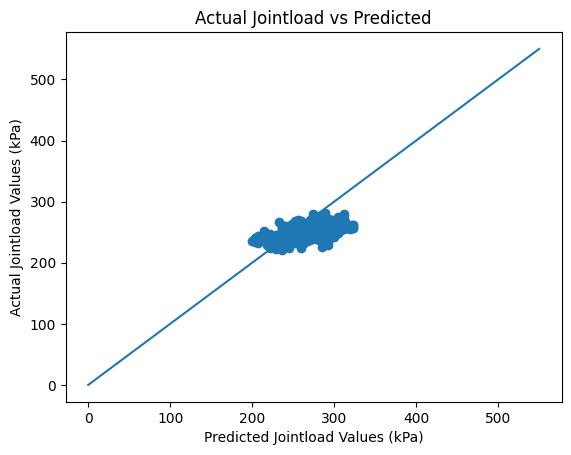

In [207]:
# Graph predicted vs actual
test_mags = get_magnitudes(results)
print(np.shape(test_mags))
cnn_predicted_mags = get_magnitudes(predictions)
print(np.shape(cnn_predicted_mags))
plt.scatter(test_mags, cnn_predicted_mags)
plt.plot(np.linspace(0, 550, 100), np.linspace(0, 550, 100))
plt.title("Actual Jointload vs Predicted")
plt.ylabel("Actual Jointload Values (kPa)")
plt.xlabel("Predicted Jointload Values (kPa)")

Text(0.5, 0, 'Time (Ms)')

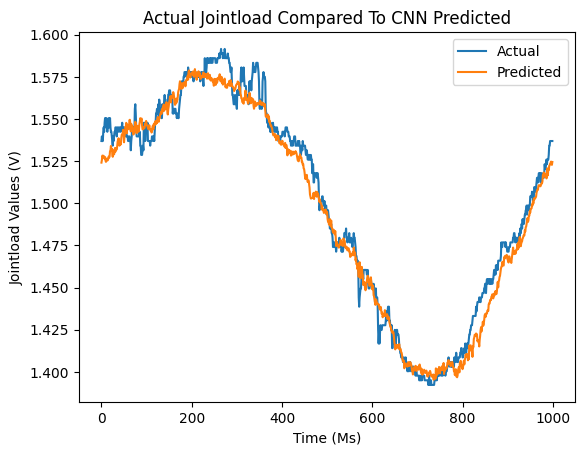

In [210]:
values = 200
plt.plot(np.arange(0, 1000), results[values], label = 'Actual')
plt.plot(np.arange(0, 1000), predictions[values], label = 'Predicted')
plt.legend()
plt.title("Actual Jointload Compared To CNN Predicted")
plt.ylabel("Jointload Values (V)")
plt.xlabel("Time (Ms)")

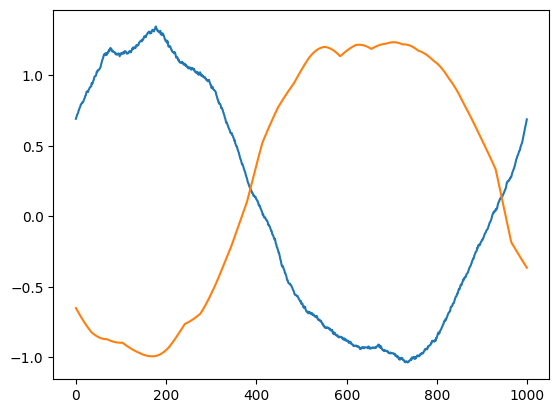

In [211]:
plt.plot(np.arange(0, 1000), data[values])